In [1]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import theano.tensor as tt
import pymc3_ext as pmx
import arviz as az
import corner
from astropy import constants
from astropy.time import Time

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


In [2]:
xo.__version__

'0.6.0'

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo

# Set random seed for reproducibility
np.random.seed(42)

# Define the true orbital parameters
true_period = 150.0 * 365.25
true_t0 = 0.0
true_a = 30  # semi-major axis in AU
true_incl = np.radians(89)  # nearly edge-on
true_ecc = 0.1
true_omega = np.pi/4

# Create the true orbit
true_orbit = xo.orbits.KeplerianOrbit(
    period=true_period,
    t0=true_t0,
    a=true_a,
    incl=true_incl,
    ecc=true_ecc,
    omega=true_omega
)

t_obs = np.array([10.0 * 365.25, 50.0 * 365.25, 90.0 * 365.25, 150.0 * 365.25, 190.0 * 365.25])  
x_obs, y_obs, z_obs = true_orbit.get_relative_position(t_obs)

In [14]:
with pm.Model() as model:
    period = pm.Normal("period", mu=150.0 * 365.25, sd=5.0)
    t0 = pm.Normal("t0", mu=0.0, sd=0.1)
    a = pm.Normal("a", mu=30., sd=1.)
    incl = pm.Normal("incl", mu=np.radians(89), sd=np.radians(1))
    ecc = pm.Beta("ecc", alpha=2, beta=20)
    omega = pm.Uniform("omega", lower=-np.pi, upper=np.pi)
    
    orbit = xo.orbits.KeplerianOrbit(
        period=period,
        t0=t0,
        a=a,
        incl=incl,
        ecc=ecc,
        omega=omega
    )
    
    x, y, z = orbit.get_relative_position(t_obs)
    
    trace = pm.sample(1000, tune=1000, cores=1)

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [omega, ecc, incl, a, t0, period]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [15]:
samples = pm.trace_to_dataframe(trace)

In [16]:
t_orbit = np.linspace(0, 200 * 365.25, 1000)

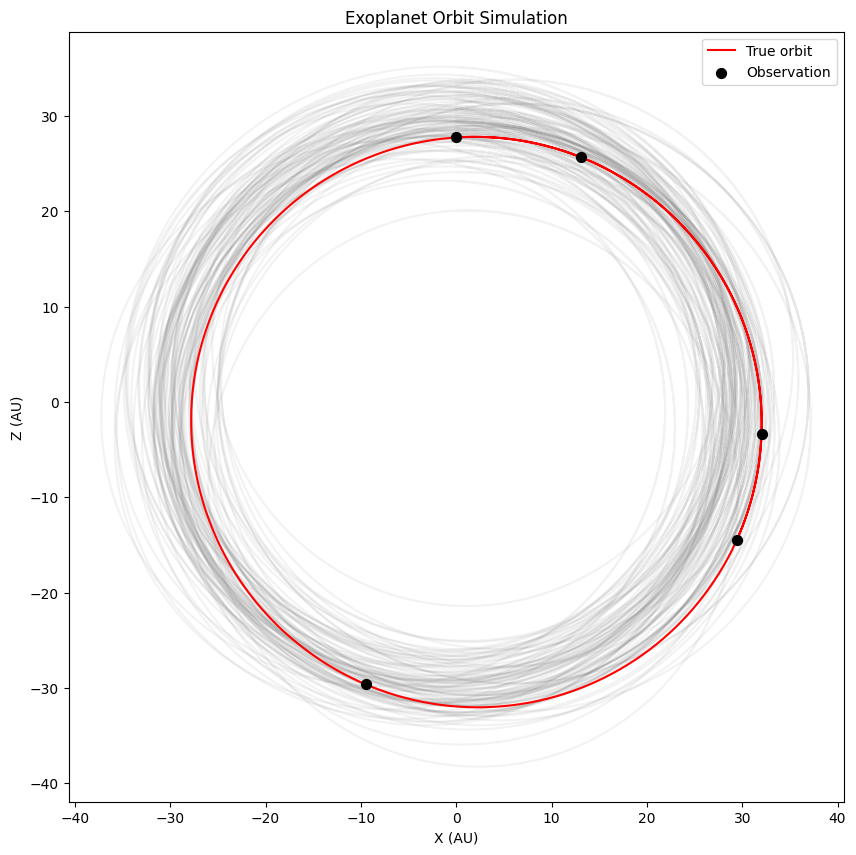

True Parameters:
Period: 54787.50 days
Semi-major axis: 30.000 AU
Inclination: 1.55 degrees
Eccentricity: 0.100
Argument of periastron: 0.79 degrees
Parameter    True Value    Mean    Std    16th Percentile    50th Percentile    84th Percentile    Precision (%)
--------------------------------------------------------------------------------------------------------------
period        54787.500 54787.538  4.920          54782.643          54787.548          54792.245            0.00
a                30.000   29.995  0.990             29.045             29.970             30.983            0.02
incl             89.000   88.988  0.940             88.063             89.013             89.895            0.01
ecc               0.100    0.091  0.059              0.035              0.079              0.149            8.80
omega            45.000   -1.728 101.259           -121.559             -0.882            116.800          103.84


In [17]:
plt.figure(figsize=(10, 10))

for i in range(100):
    orbit_i = xo.orbits.KeplerianOrbit(
        period=samples['period'][i],
        t0=samples['t0'][i],
        a=samples['a'][i],
        incl=samples['incl'][i],
        ecc=samples['ecc'][i],
        omega=samples['omega'][i]
    )
    x, y, z = orbit_i.get_relative_position(t_orbit)
    plt.plot(x.eval(), z.eval(), color='gray', alpha=0.1)

x_true, y_true, z_true = true_orbit.get_relative_position(t_orbit)
plt.plot(x_true.eval(), z_true.eval(), color='red', label='True orbit')

plt.scatter(x_obs.eval(), z_obs.eval(), color='black', s=50, zorder=10, label='Observation')

plt.xlabel('X (AU)')
plt.ylabel('Z (AU)')
plt.title('Exoplanet Orbit Simulation')
plt.legend()
plt.axis('equal')
plt.grid(False)
plt.show()

print(f"True Parameters:")
print(f"Period: {true_period:.2f} days")
print(f"Semi-major axis: {true_a:.3f} AU")
print(f"Inclination: {(true_incl):.2f} degrees")
print(f"Eccentricity: {true_ecc:.3f}")
print(f"Argument of periastron: {(true_omega):.2f} degrees")

# Function to calculate precision
def calculate_precision(true_value, mean_value):
    return abs((mean_value - true_value) / true_value) * 100

# Print true parameters and sampled parameter statistics
print("Parameter    True Value    Mean    Std    16th Percentile    50th Percentile    84th Percentile    Precision (%)")
print("-" * 110)

params = {
    'period': true_period,
    'a': true_a,
    'incl': true_incl,
    'ecc': true_ecc,
    'omega': true_omega
}

for param, true_value in params.items():
    mean = samples[param].mean()
    std = samples[param].std()
    percentiles = np.percentile(samples[param], [16, 50, 84])
    precision = calculate_precision(true_value, mean)
    
    # Convert inclination and omega to degrees for display
    if param in ['incl', 'omega']:
        true_value = np.degrees(true_value)
        mean = np.degrees(mean)
        std = np.degrees(std)
        percentiles = np.degrees(percentiles)
    
    print(f"{param:<11} {true_value:11.3f} {mean:8.3f} {std:6.3f} {percentiles[0]:18.3f} {percentiles[1]:18.3f} {percentiles[2]:18.3f} {precision:15.2f}")

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omega, ecc, incl, a, t0, period]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrad

/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.



Statistics for 1 observation:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.414 ± 4.820               0.00
a                40.000    39.986 ± 1.916               0.04
incl             89.000    88.973 ± 0.944               0.03
ecc               0.100    0.093 ± 0.057               7.49
omega            45.000    2.326 ± 116.689              94.83


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omega, ecc, incl, a, t0, period]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrad

/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.



Statistics for 2 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.489 ± 4.692               0.00
a                40.000    39.931 ± 1.961               0.17
incl             89.000    88.998 ± 1.043               0.00
ecc               0.100    0.092 ± 0.057               8.14
omega            45.000    1.409 ± 124.204              96.87


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omega, ecc, incl, a, t0, period]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrad

/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.



Statistics for 3 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.441 ± 5.033               0.00
a                40.000    40.044 ± 2.042               0.11
incl             89.000    89.010 ± 1.002               0.01
ecc               0.100    0.093 ± 0.058               7.36
omega            45.000    -1.017 ± 120.004             102.26


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omega, ecc, incl, a, t0, period]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrad

/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.



Statistics for 4 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.691 ± 5.245               0.01
a                40.000    39.939 ± 1.913               0.15
incl             89.000    88.987 ± 1.017               0.02
ecc               0.100    0.091 ± 0.057               9.31
omega            45.000    1.670 ± 121.162              96.29


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omega, ecc, incl, a, t0, period]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrad

/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.



Statistics for 5 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.530 ± 5.039               0.00
a                40.000    40.010 ± 2.012               0.02
incl             89.000    89.011 ± 1.029               0.01
ecc               0.100    0.090 ± 0.055              10.49
omega            45.000    -2.291 ± 121.831             105.09


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omega, ecc, incl, a, t0, period]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrad

/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.



Statistics for 6 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.552 ± 4.885               0.00
a                40.000    40.044 ± 1.985               0.11
incl             89.000    89.013 ± 0.987               0.01
ecc               0.100    0.091 ± 0.059               8.84
omega            45.000    1.769 ± 119.865              96.07


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omega, ecc, incl, a, t0, period]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.



Statistics for 7 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.580 ± 4.804               0.00
a                40.000    39.960 ± 2.044               0.10
incl             89.000    88.999 ± 0.970               0.00
ecc               0.100    0.091 ± 0.058               8.88
omega            45.000    -2.257 ± 125.021             105.02


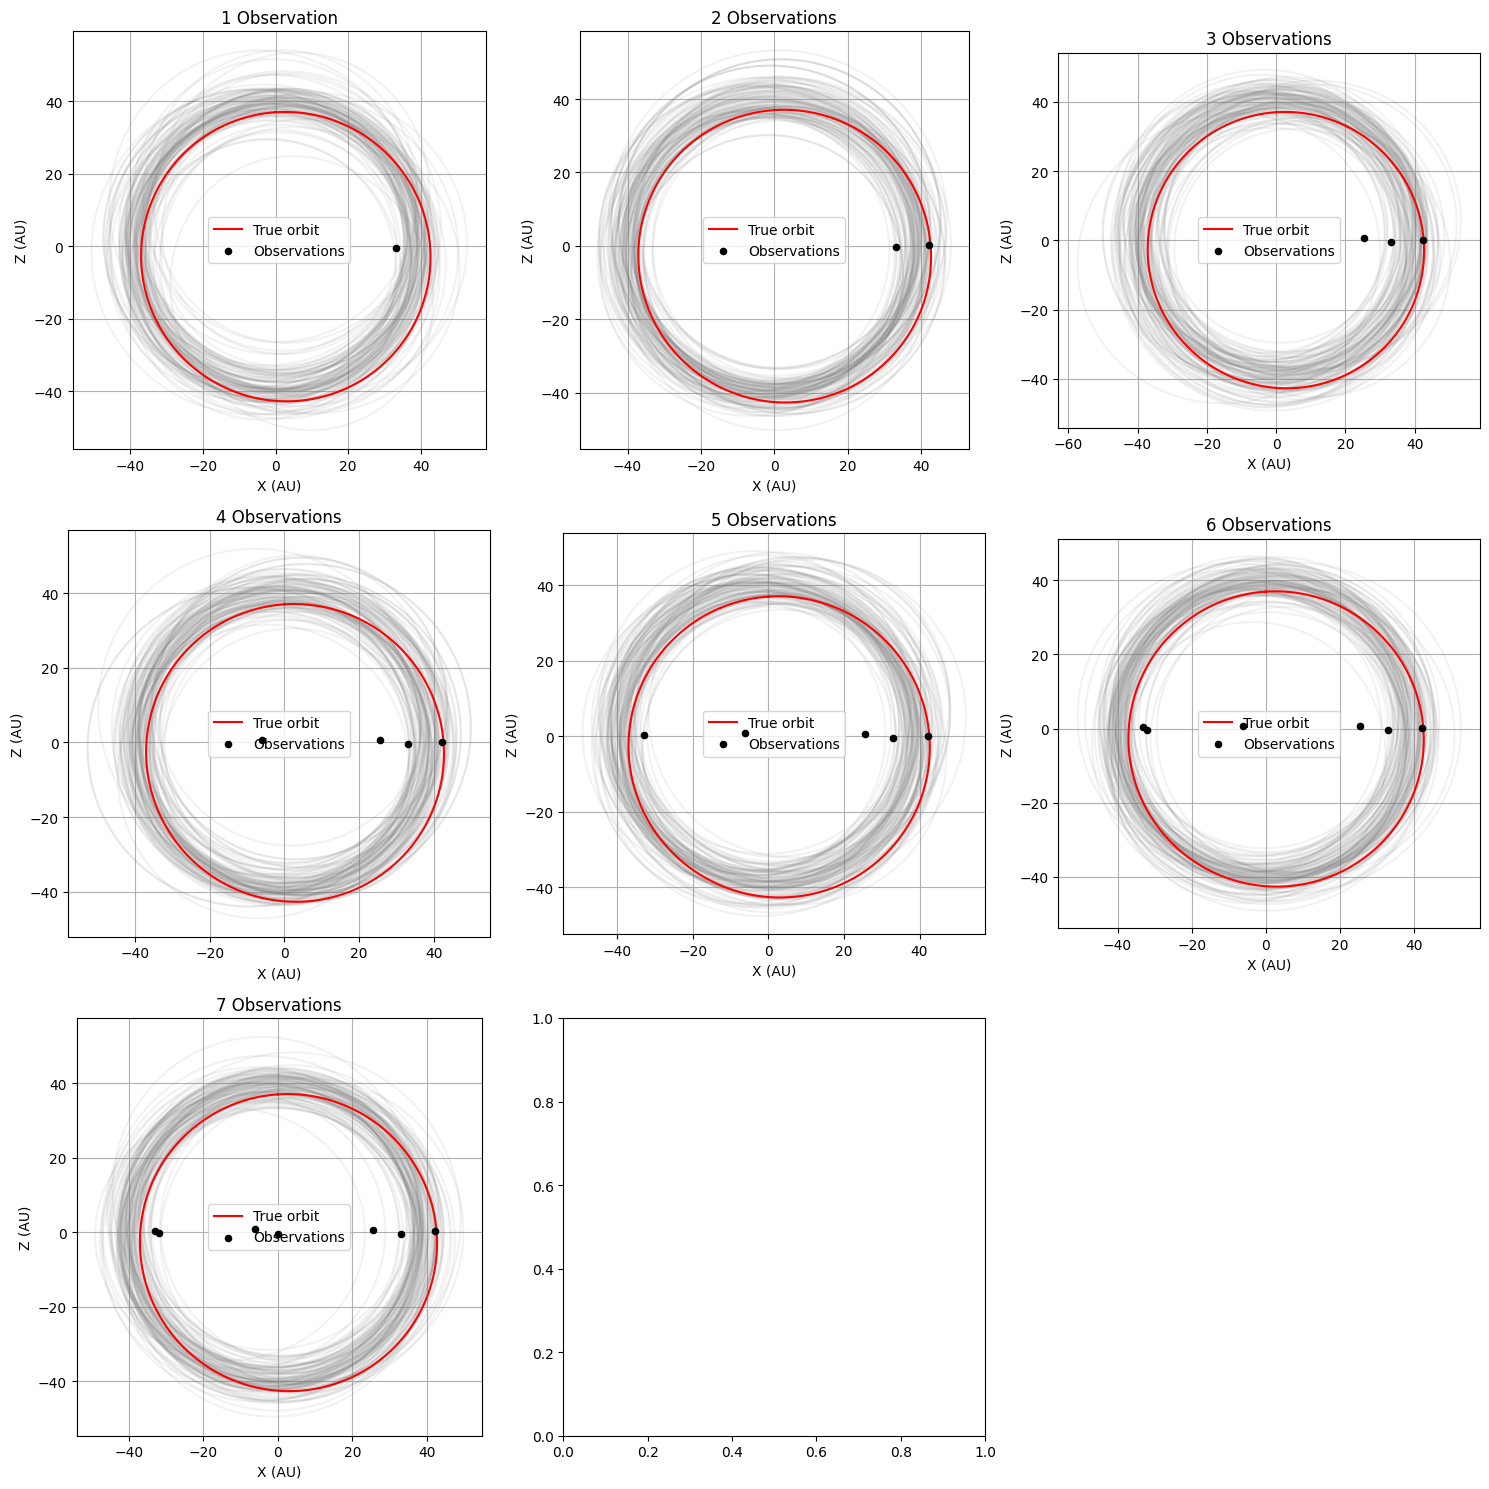

In [18]:
np.random.seed(42)

# Define the true orbital parameters
true_period = 10.0 * 365.25
true_t0 = 0.0
true_a = 40.0  # semi-major axis in AU
true_incl = np.radians(89)  # nearly edge-on
true_ecc = 0.1
true_omega = np.pi/4

# Create the true orbit
true_orbit = xo.orbits.KeplerianOrbit(
    period=true_period,
    t0=true_t0,
    a=true_a,
    incl=true_incl,
    ecc=true_ecc,
    omega=true_omega
)

# Generate 7 observation epochs
t_obs = np.linspace(0, true_period, 8)[1:]  # 7 equally spaced observations
x_obs, y_obs, z_obs = true_orbit.get_relative_position(t_obs)

# Function to sample orbital parameters
def sample_orbits(num_observations):
    with pm.Model() as model:
        # Orbit parameters
        period = pm.Normal("period", mu=true_period, sd=5.0)
        t0 = pm.Normal("t0", mu=0.0, sd=0.1)
        a = pm.Normal("a", mu=true_a, sd=2.)
        incl = pm.Normal("incl", mu=np.radians(89), sd=np.radians(1))
        ecc = pm.Beta("ecc", alpha=2, beta=20)
        omega = pm.Uniform("omega", lower=-np.pi, upper=np.pi)
        
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            a=a,
            incl=incl,
            ecc=ecc,
            omega=omega
        )
        
        # Compute position for the observation epochs
        x, y, z = orbit.get_relative_position(t_obs[:num_observations])
        
        # Sample
        trace = pm.sample(1000, tune=1000, cores=2)
    
    return pm.trace_to_dataframe(trace)

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Compute orbits for plotting
t_orbit = np.linspace(0, true_period, 1000)
x_true, y_true, z_true = true_orbit.get_relative_position(t_orbit)

# Function to calculate precision
def calculate_precision(true_value, mean_value):
    return abs((mean_value - true_value) / true_value) * 100

# Function to print statistics
def print_statistics(samples, num_obs):
    print(f"\nStatistics for {num_obs} observation{'s' if num_obs > 1 else ''}:")
    print("Parameter    True Value    Estimated Value           Precision (%)")
    print("-" * 70)

    params = {
        'period': true_period,
        'a': true_a,
        'incl': true_incl,
        'ecc': true_ecc,
        'omega': true_omega
    }

    for param, true_value in params.items():
        mean = samples[param].mean()
        std = samples[param].std()
        lower, upper = np.percentile(samples[param], [16, 84])
        precision = calculate_precision(true_value, mean)
        
        # Convert inclination and omega to degrees for display
        if param in ['incl', 'omega']:
            true_value = np.degrees(true_value)
            mean = np.degrees(mean)
            lower = np.degrees(lower)
            upper = np.degrees(upper)
        
        print(f"{param:<11} {true_value:11.3f}    {mean:.3f} ± {upper-mean:.3f}    {precision:15.2f}")

# Loop through increasing number of observations
for i in range(7):
    num_obs = i + 1
    ax = axes[i]
    
    # Sample orbits
    samples = sample_orbits(num_obs)
    
    # Plot sample orbits
    for j in range(100):  # Plot fewer orbits for clarity
        orbit_j = xo.orbits.KeplerianOrbit(
            period=samples['period'][j],
            t0=samples['t0'][j],
            a=samples['a'][j],
            incl=samples['incl'][j],
            ecc=samples['ecc'][j],
            omega=samples['omega'][j]
        )
        x, y, z = orbit_j.get_relative_position(t_orbit)
        ax.plot(x.eval(), z.eval(), color='gray', alpha=0.1)
    
    # Plot true orbit
    ax.plot(x_true.eval(), z_true.eval(), color='red', label='True orbit')
    
    # Plot observation points
    ax.scatter(x_obs[:num_obs].eval(), y_obs[:num_obs].eval(), color='black', s=20, zorder=10, label='Observations')
    
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Z (AU)')
    ax.set_title(f'{num_obs} Observation{"s" if num_obs > 1 else ""}')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True)

    # Print statistics for this iteration
    print_statistics(samples, num_obs)

# Remove the last (empty) subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
NUTS: [omega, ecc, incl, a, t0, period]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 55 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9611290234670412, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks



Statistics for 1 observation:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.472 ± 5.354               0.00
a                30.000    30.658 ± 0.770               2.19
incl             89.000    89.026 ± 0.032               0.03
ecc               0.100    0.067 ± 0.035              32.55
omega            45.000    80.963 ± 55.691              79.92


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
NUTS: [omega, ecc, incl, a, t0, period]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks



Statistics for 2 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3651.777 ± 4.421               0.02
a                30.000    29.998 ± 0.020               0.01
incl             89.000    89.028 ± 0.030               0.03
ecc               0.100    0.100 ± 0.000               0.03
omega            45.000    44.942 ± 0.399               0.13


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
NUTS: [omega, ecc, incl, a, t0, period]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks



Statistics for 3 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.752 ± 2.637               0.01
a                30.000    30.001 ± 0.012               0.00
incl             89.000    89.000 ± 0.018               0.00
ecc               0.100    0.100 ± 0.000               0.06
omega            45.000    45.017 ± 0.250               0.04


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
NUTS: [omega, ecc, incl, a, t0, period]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks



Statistics for 4 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.334 ± 1.179               0.00
a                30.000    29.998 ± 0.006               0.01
incl             89.000    89.005 ± 0.013               0.01
ecc               0.100    0.100 ± 0.000               0.17
omega            45.000    44.979 ± 0.104               0.05


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
NUTS: [omega, ecc, incl, a, t0, period]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks



Statistics for 5 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.190 ± 0.594               0.01
a                30.000    30.000 ± 0.004               0.00
incl             89.000    89.006 ± 0.012               0.01
ecc               0.100    0.100 ± 0.000               0.14
omega            45.000    44.961 ± 0.054               0.09


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
NUTS: [omega, ecc, incl, a, t0, period]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks



Statistics for 6 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.464 ± 0.316               0.00
a                30.000    30.001 ± 0.004               0.00
incl             89.000    89.006 ± 0.012               0.01
ecc               0.100    0.100 ± 0.000               0.06
omega            45.000    44.977 ± 0.042               0.05


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
NUTS: [omega, ecc, incl, a, t0, period]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks



Statistics for 7 observations:
Parameter    True Value    Estimated Value           Precision (%)
----------------------------------------------------------------------
period         3652.500    3652.283 ± 0.184               0.01
a                30.000    30.001 ± 0.004               0.00
incl             89.000    88.995 ± 0.011               0.01
ecc               0.100    0.100 ± 0.000               0.12
omega            45.000    44.970 ± 0.043               0.07


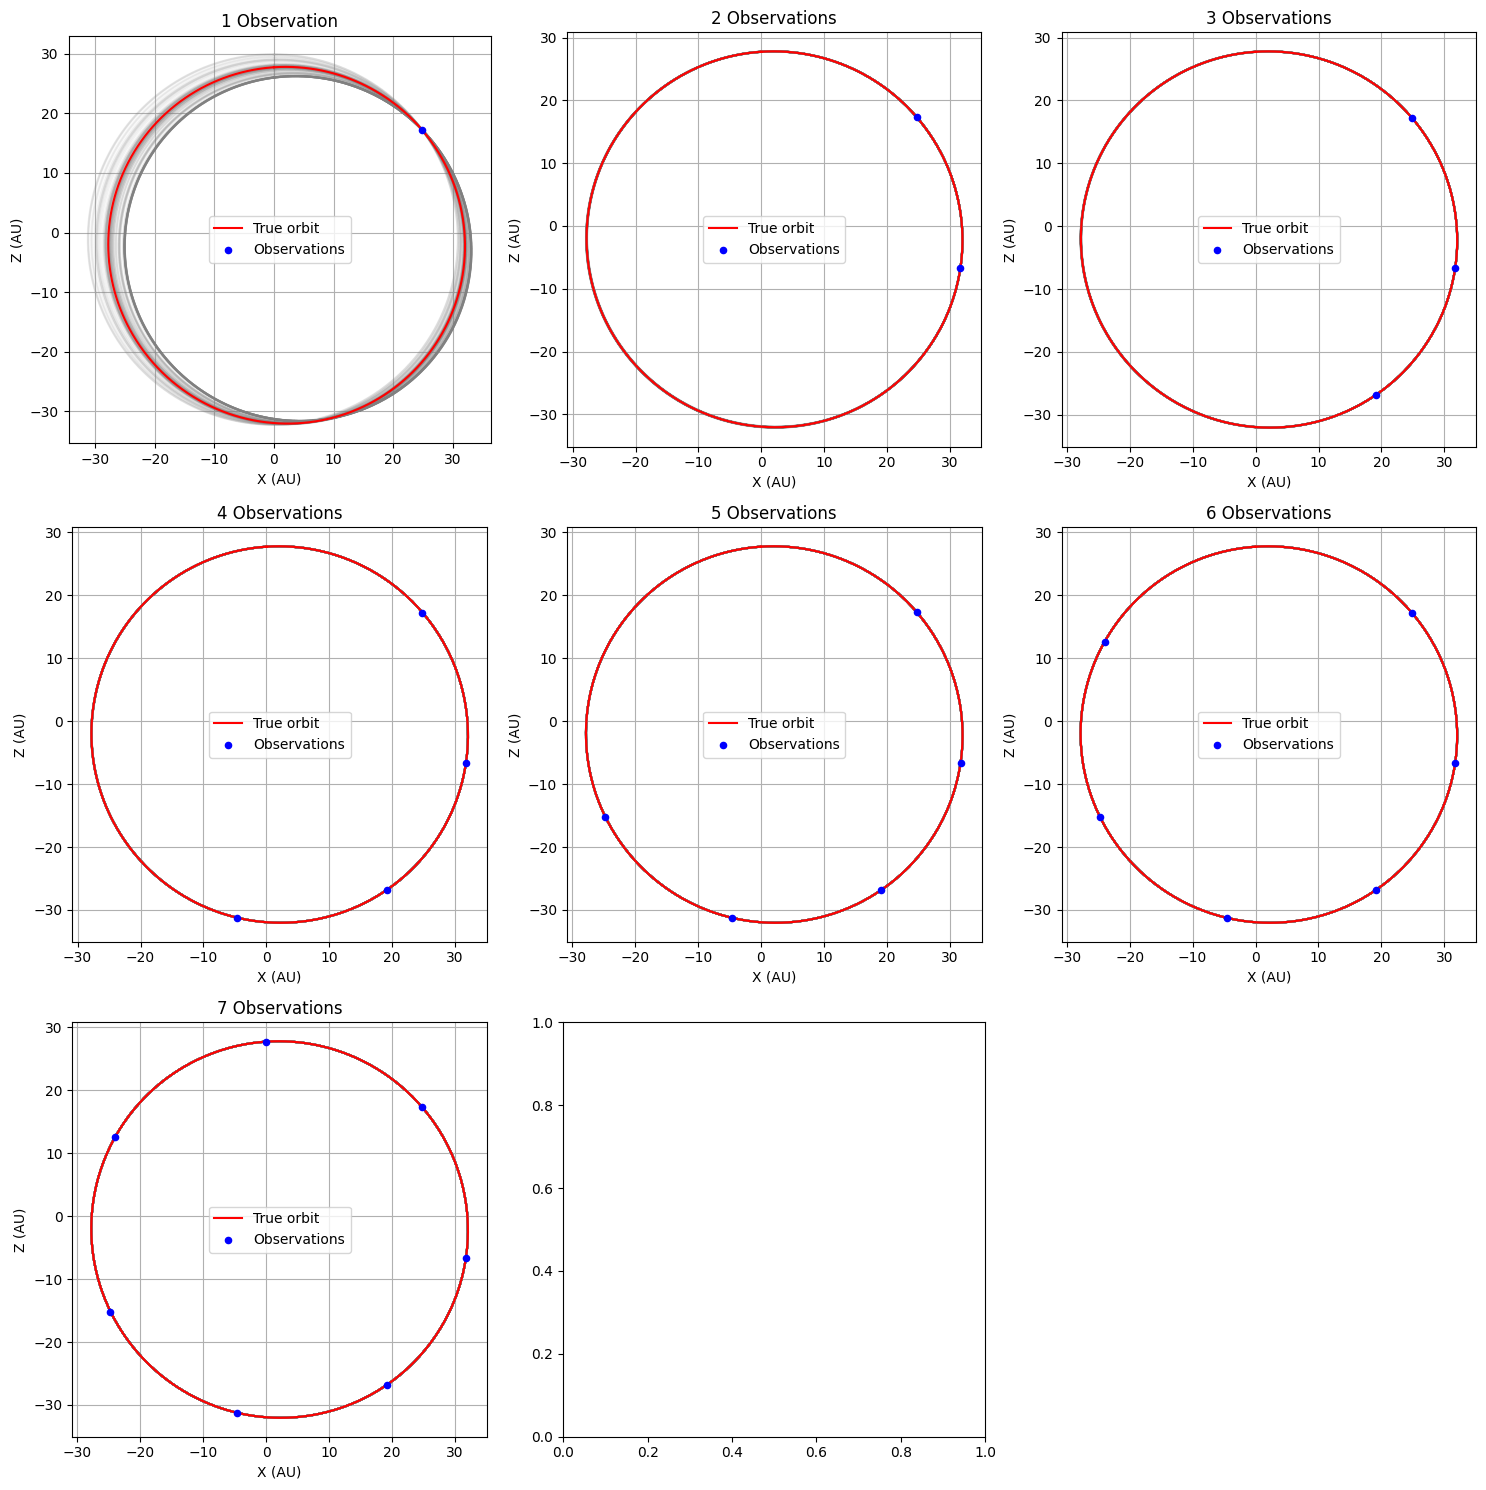

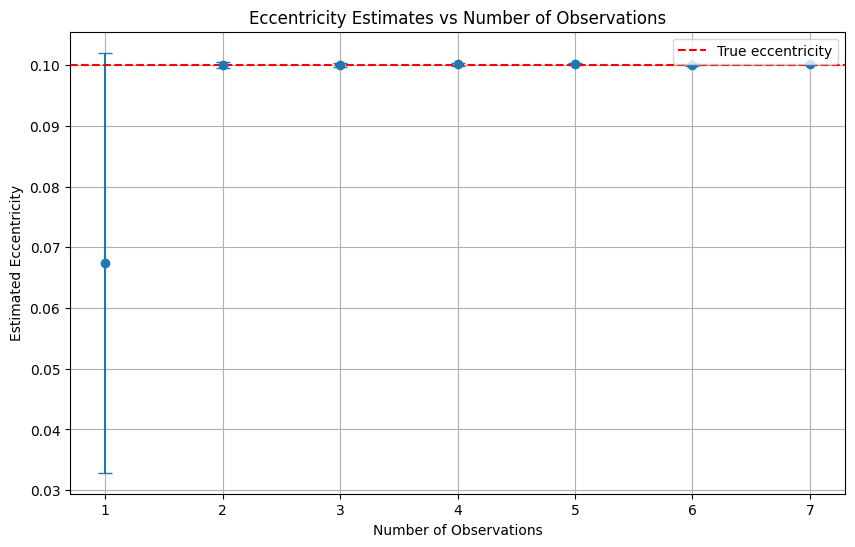


Eccentricity Estimates:
Observations    Estimate    Uncertainty    Precision (%)
------------------------------------------------------------
1              0.06745    ±0.03459              32.55
2              0.10003    ±0.00046               0.03
3              0.10006    ±0.00035               0.06
4              0.10017    ±0.00025               0.17
5              0.10014    ±0.00018               0.14
6              0.10006    ±0.00012               0.06
7              0.10012    ±0.00009               0.12


In [22]:
np.random.seed(42)

# Define the true orbital parameters
true_period = 10.0 * 365.25
true_t0 = 0.0
true_a = 30.0  # semi-major axis in AU
true_incl = np.radians(89)  # nearly edge-on
true_ecc = 0.1
true_omega = np.pi/4

# Create the true orbit
true_orbit = xo.orbits.KeplerianOrbit(
    period=true_period,
    t0=true_t0,
    a=true_a,
    incl=true_incl,
    ecc=true_ecc,
    omega=true_omega
)

# Generate 7 observation epochs
t_obs = np.linspace(0, true_period, 8)[1:]  # 7 equally spaced observations
x_obs, y_obs, z_obs = true_orbit.get_relative_position(t_obs)
x_obs, y_obs, z_obs = x_obs.eval(), y_obs.eval(), z_obs.eval()

# Add some noise to the observations
np.random.seed(42)
noise_level = 0.01
x_obs += np.random.normal(0, noise_level, size=len(x_obs))
y_obs += np.random.normal(0, noise_level, size=len(y_obs))

# Function to sample orbital parameters
def sample_orbits(num_observations):
    with pm.Model() as model:
        # Orbit parameters
        period = pm.Normal("period", mu=true_period, sd=5.0)
        t0 = pm.Normal("t0", mu=true_t0, sd=0.1)
        a = pm.Normal("a", mu=true_a, sd=1.)
        incl = pm.Normal("incl", mu=np.radians(89), sd=np.radians(1))
        ecc = pm.Beta("ecc", alpha=2, beta=20)
        omega = pm.Uniform("omega", lower=-np.pi, upper=np.pi)
        
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            a=a,
            incl=incl,
            ecc=ecc,
            omega=omega
        )
        
        # Compute position for the observation epochs
        x, y, z = orbit.get_relative_position(t_obs[:num_observations])
        
        # Add likelihood
        pm.Normal("x_obs", mu=x, sd=noise_level, observed=x_obs[:num_observations])
        pm.Normal("y_obs", mu=y, sd=noise_level, observed=y_obs[:num_observations])
        pm.Normal("z_obs", mu=z, sd=noise_level, observed=z_obs[:num_observations])
        
        # Sample
        trace = pmx.sample(
            tune=1000,
            draws=1000,
            chains=1,
            cores=4,
            target_accept=0.9,
        )
    
    return pm.trace_to_dataframe(trace)

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Compute orbits for plotting
t_orbit = np.linspace(0, true_period, 1000)
x_true, y_true, z_true = true_orbit.get_relative_position(t_orbit)

# Lists to store eccentricity estimates
ecc_means = []
ecc_errors = []

# Function to calculate precision
def calculate_precision(true_value, mean_value):
    return abs((mean_value - true_value) / true_value) * 100

# Function to print statistics
def print_statistics(samples, num_obs):
    print(f"\nStatistics for {num_obs} observation{'s' if num_obs > 1 else ''}:")
    print("Parameter    True Value    Estimated Value           Precision (%)")
    print("-" * 70)

    params = {
        'period': true_period,
        'a': true_a,
        'incl': true_incl,
        'ecc': true_ecc,
        'omega': true_omega
    }

    for param, true_value in params.items():
        mean = samples[param].mean()
        std = samples[param].std()
        lower, upper = np.percentile(samples[param], [16, 84])
        precision = calculate_precision(true_value, mean)
        
        # Convert inclination and omega to degrees for display
        if param in ['incl', 'omega']:
            true_value = np.degrees(true_value)
            mean = np.degrees(mean)
            lower = np.degrees(lower)
            upper = np.degrees(upper)
        
        print(f"{param:<11} {true_value:11.3f}    {mean:.3f} ± {upper-mean:.3f}    {precision:15.2f}")
        
        if param == 'ecc':
            ecc_means.append(mean)
            ecc_errors.append(upper - mean)

# Loop through increasing number of observations
for i in range(7):
    num_obs = i + 1
    ax = axes[i]
    
    # Sample orbits
    samples = sample_orbits(num_obs)
    
    # Plot sample orbits
    for j in range(100):  # Plot fewer orbits for clarity
        orbit_j = xo.orbits.KeplerianOrbit(
            period=samples['period'][j],
            t0=samples['t0'][j],
            a=samples['a'][j],
            incl=samples['incl'][j],
            ecc=samples['ecc'][j],
            omega=samples['omega'][j]
        )
        x, y, z = orbit_j.get_relative_position(t_orbit)
        ax.plot(x.eval(), z.eval(), color='gray', alpha=0.1)
    
    # Plot true orbit
    ax.plot(x_true.eval(), z_true.eval(), color='red', label='True orbit')
    
    # Plot observation points
    ax.scatter(x_obs[:num_obs], z_obs[:num_obs], color='blue', s=20, zorder=10, label='Observations')
    
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Z (AU)')
    ax.set_title(f'{num_obs} Observation{"s" if num_obs > 1 else ""}')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True)

    # Print statistics for this iteration
    print_statistics(samples, num_obs)

# Remove the last (empty) subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Plot eccentricity estimates
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, 8), ecc_means, yerr=ecc_errors, fmt='o', capsize=5)
plt.axhline(true_ecc, color='r', linestyle='--', label='True eccentricity')
plt.xlabel('Number of Observations')
plt.ylabel('Estimated Eccentricity')
plt.title('Eccentricity Estimates vs Number of Observations')
plt.legend()
plt.grid(True)
plt.show()

# Print final eccentricity estimates
print("\nEccentricity Estimates:")
print("Observations    Estimate    Uncertainty    Precision (%)")
print("-" * 60)
for i, (mean, error) in enumerate(zip(ecc_means, ecc_errors), 1):
    precision = calculate_precision(true_ecc, mean)
    print(f"{i:<14} {mean:.5f}    ±{error:.5f}    {precision:15.2f}")

In [24]:
np.linspace(0, true_period, 8)[1:][0]

521.7857142857143

In [3]:
np.random.seed(42)

true_period = 10.0 * 365.25
true_t0 = 0.0
true_a = 30.0  # semi-major axis in AU
true_incl = np.radians(89)  
true_ecc = 0.1
true_omega = np.pi/4

true_orbit = xo.orbits.KeplerianOrbit(
    period=true_period,
    t0=true_t0,
    a=true_a,
    incl=true_incl,
    ecc=true_ecc,
    omega=true_omega
)

t_obs = np.linspace(0, true_period, 8)[1:][0]  
x_obs, y_obs, z_obs = true_orbit.get_relative_position(t_obs)
x_obs, y_obs, z_obs = x_obs.eval(), y_obs.eval(), z_obs.eval()

noise_level = 0.1
x_obs += np.random.normal(0, noise_level)
y_obs += np.random.normal(0, noise_level)

with pm.Model() as model:
    period = pm.Normal("period", mu=true_period, sd=5.0)
    t0 = pm.Normal("t0", mu=true_t0, sd=0.1)
    a = pm.Normal("a", mu=true_a, sd=1.)
    incl = pm.Normal("incl", mu=np.radians(89), sd=np.radians(1))
    ecc = pm.Beta("ecc", alpha=2, beta=20)
    omega = pm.Uniform("omega", lower=-np.pi, upper=np.pi)
    
    orbit = xo.orbits.KeplerianOrbit(
        period=period,
        t0=t0,
        a=a,
        incl=incl,
        ecc=ecc,
        omega=omega
    )
    
    x, y, z = orbit.get_relative_position(t_obs)
    
    pm.Normal("x_obs", mu=x, sd=noise_level, observed=x_obs)
    pm.Normal("y_obs", mu=y, sd=noise_level, observed=y_obs)
    pm.Normal("z_obs", mu=z, sd=noise_level, observed=z_obs)
    
    # Sample
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        chains=1,
        cores=4,
        target_accept=0.9,
    )

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
NUTS: [omega, ecc, incl, a, t0, period]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 8 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7739682856979891, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [4]:
samples = pm.trace_to_dataframe(trace)
t_orbit = np.linspace(0, true_period, 100)
x_true, y_true, z_true = true_orbit.get_relative_position(t_orbit)

for j in range(100):  # Plot fewer orbits for clarity
    orbit_j = xo.orbits.KeplerianOrbit(
        period=samples['period'][j],
        t0=samples['t0'][j],
        a=samples['a'][j],
        incl=samples['incl'][j],
        ecc=samples['ecc'][j],
        omega=samples['omega'][j]
    )
    x, y, z = orbit_j.get_relative_position(t_orbit)
    plt.plot(x.eval(), z.eval(), color='gray', alpha=0.1)
plt.plot(x_true.eval(), z_true.eval(), color='red')

ValueError: Cannot compute test value: input 0 (Elemwise{Cast{float64}}.0) of Op Elemwise{neg,no_inplace}(Elemwise{Cast{float64}}.0) missing default value.  
Backtrace when that variable is created:

  File "/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_19862/1922497345.py", line 10, in <module>
    true_orbit = xo.orbits.KeplerianOrbit(
  File "/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/exoplanet/orbits/keplerian.py", line 133, in __init__
    inputs = _get_consistent_inputs(
  File "/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/exoplanet/orbits/keplerian.py", line 859, in _get_consistent_inputs
    a = as_tensor_variable(to_unit(a, u.R_sun))
  File "/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/exoplanet/utils.py", line 22, in as_tensor_variable
    return t.astype(dtype)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import arviz as az
import corner
from astropy import constants

# Set random seed for reproducibility
np.random.seed(42)

# True orbital parameters
true_period = 1000.0  # days
true_t0 = 2458000  # BJD
true_parallax = 25.0  # mas
true_a_ang = 100.0  # mas
true_incl = np.radians(60)
true_ecc = 0.3
true_omega = np.radians(30)
true_Omega = np.radians(80)

# Conversion constant
au_to_R_sun = (constants.au / constants.R_sun).value

# Create the true orbit
true_orbit = xo.orbits.KeplerianOrbit(
    period=true_period,
    t0=true_t0,
    a=true_a_ang * au_to_R_sun / true_parallax,
    incl=true_incl,
    ecc=true_ecc,
    omega=true_omega,
    Omega=true_Omega
)

# Generate observations
n_observations = 20
t_obs = np.linspace(true_t0, true_t0 + 2*true_period, n_observations)[1]
ra, dec = true_orbit.get_relative_angles(t_obs, parallax=true_parallax)

# Convert to mas
ra *= 1000
dec *= 1000

# Add some noise to the observations
noise_level = 0.1  # mas
ra += np.random.normal(0, noise_level)
dec += np.random.normal(0, noise_level)

In [14]:
ra.eval()

array(79451.80068373)

In [15]:
with pm.Model() as model:
    # Priors
    log_period = pm.Normal("log_period", mu=np.log(true_period), sd=1)
    period = pm.Deterministic("period", tt.exp(log_period))
    t0 = pm.Normal("t0", mu=2458000, sd=10)
    
    # Parallax prior (assuming Gaia-like uncertainty)
    plx = pm.Normal("plx", mu=true_parallax, sd=0.05)
    
    a_ang = pm.Normal("a_ang", mu=true_a_ang, sd=10)
    a = pm.Deterministic("a", a_ang * au_to_R_sun / plx)
    
    cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1)
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    ecc = pm.Beta("ecc", alpha=1, beta=5)
    
    omega = pmx.Angle("omega")
    Omega = pmx.Angle("Omega")
    
    orbit = xo.orbits.KeplerianOrbit(
        period=period,
        t0=t0,
        a=a,
        incl=incl,
        ecc=ecc,
        omega=omega,
        Omega=Omega
    )
    ra_model, dec_model = orbit.get_relative_angles(t_obs, parallax=plx)
    
    ra_model *= 1000
    dec_model *= 1000
    
    # Add likelihood
    pm.Normal("ra_obs", mu=ra_model, sd=noise_level, observed=ra)
    pm.Normal("dec_obs", mu=dec_model, sd=noise_level, observed=dec)
    
    # Sample
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        chains=1,
        cores=4,
        target_accept=0.9,
    )

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
NUTS: [Omega, omega, ecc, cos_incl, a_ang, plx, t0, log_period]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


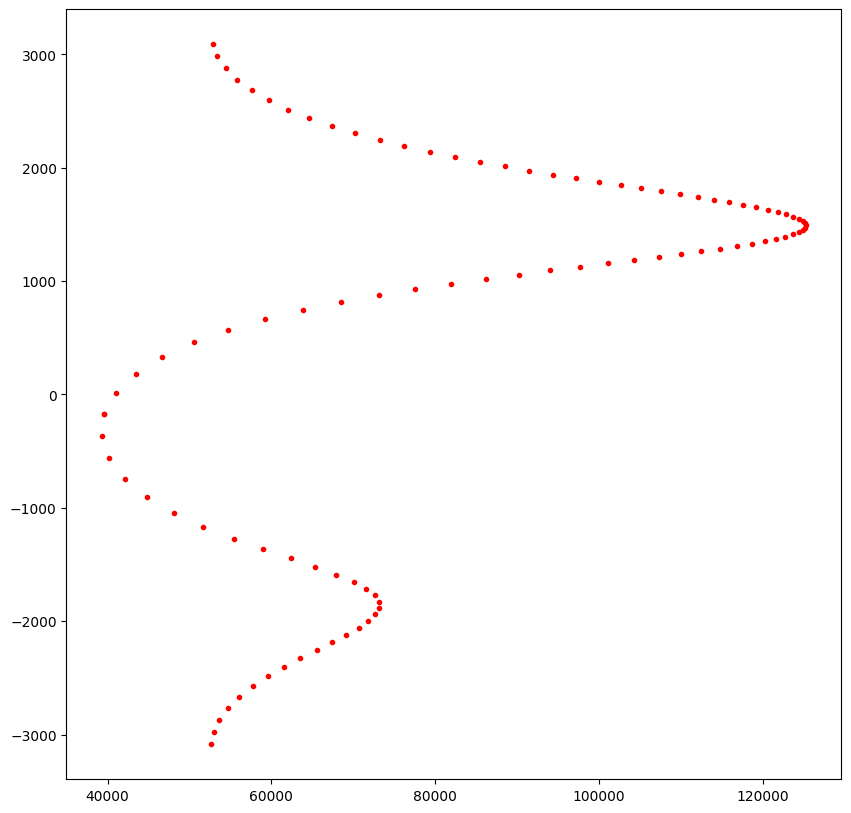

In [18]:
plt.figure(figsize=(10, 10))
t_fine = np.linspace(true_t0, true_t0 + 2*true_period, 100)
ra_true, dec_true = true_orbit.get_relative_angles(t_fine, parallax=true_parallax)
ra_true *= 1000 
dec_true *= 1000 
plt.plot(ra_true.eval(), dec_true.eval(), 'r.', label='True orbit')

In [208]:
np.random.seed(42)
deg = np.pi / 180.0

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

true_a_ang = 0.324  # arcsec
true_parallax = 25  # mas
true_a = true_a_ang * au_to_R_sun / true_parallax
true_ecc = 0.7
true_incl = 96.0 * deg  # [rad]
true_omega = 251.6 * deg - np.pi  
true_Omega = 159.6 * deg
true_period = 28.8 * 365.25  # days

true_T0 = Time(1989.92, format="decimalyear")
true_T0.format = "jd"
true_T0 = true_T0.value  # [Julian Date]

true_orbit = xo.orbits.KeplerianOrbit(
    period=true_period,
    t_periastron=true_T0,
    a=true_a,
    incl=true_incl,
    ecc=true_ecc,
    omega=true_omega,
    Omega=true_Omega
)

n_observations = 7
t_obs = np.linspace(true_T0, true_T0 + true_period, 7)[1:4]
rho, theta = true_orbit.get_relative_angles(t_obs, true_parallax)
rho = rho.eval()
theta = theta.eval()

rho_err = 0.01 
theta_err = np.radians(0.5) 
rho += np.random.normal(0, rho_err)
theta += np.random.normal(0, theta_err)

theta = np.mod(theta + np.pi, 2*np.pi) - np.pi

In [209]:
t_obs

array([2449616.50001065, 2451369.70001065, 2453122.90001065])

In [210]:
true_period

10519.2

In [211]:
rho

array([0.31070998, 0.29227188, 0.18720778])

In [212]:
yr = 365.25
t_fine = np.linspace(true_T0, true_T0 + true_period + 1, 1001)[1:]


with pm.Model() as model:
    # Below we will run a version of this model where a measurement of parallax is provided
    # The measurement is in milliarcsec
    m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
        "m_plx", mu=true_parallax, sd=0.45, testval=true_parallax
    )
    plx = pm.Deterministic("plx", 1e-3 * m_plx)

    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=true_a_ang)
    a = pm.Deterministic("a", a_ang / plx)

    # We expect the period to be somewhere in the range of 25 years,
    # so we'll set a broad prior on logP
    logP = pm.Normal(
        "logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr)
    )
    P = pm.Deterministic("P", tt.exp(logP))

    omega = pmx.Angle("omega", testval=true_omega)
    Omega = pmx.Angle("Omega", testval=true_Omega)

    # For these orbits, it can also be better to fit for a phase angle
    # (relative to a reference time) instead of the time of periastron
    # passage directly
    phase = pmx.Angle("phase", testval=0.0)
    tperi = pm.Deterministic("tperi", true_T0 + P * phase / (2 * np.pi))

    # Geometric uniform prior on cos(incl)
    cos_incl = pm.Uniform(
        "cos_incl", lower=-1, upper=1, testval=np.cos(true_incl * deg)
    )
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=true_ecc)

    orbit = xo.orbits.KeplerianOrbit(
        a=a * au_to_R_sun,
        t_periastron=tperi,
        period=P,
        incl=incl,
        ecc=ecc,
        omega=omega,
        Omega=Omega,
    )
    pm.Deterministic("M_tot", orbit.m_total)

    rho_model, theta_model = orbit.get_relative_angles(t_obs, plx)
    pm.Deterministic("rho_model", rho_model)
    pm.Deterministic("theta_model", theta_model)

    # Add jitter terms to both separation and position angle
    log_rho_s = pm.Normal(
        "log_rho_s", mu=np.log(np.median(rho_err)), sd=2.0
    )
    log_theta_s = pm.Normal(
        "log_theta_s", mu=np.log(np.median(theta_err)), sd=2.0
    )
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2 * log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2 * log_theta_s))

    # define the likelihood function
    pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho)

    # We want to be cognizant of the fact that theta wraps so the following is equivalent to
    # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
    # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
    theta_diff = tt.arctan2(
        tt.sin(theta_model - theta), tt.cos(theta_model - theta)
    )
    pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

    # Set up predicted orbits for later plotting
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
    rho_save = pm.Deterministic("rho_save", rho_dense)
    theta_save = pm.Deterministic("theta_save", theta_dense)

    map_soln = model.test_point
    map_soln = pmx.optimize(map_soln, vars=[log_rho_s, log_theta_s])
    map_soln = pmx.optimize(map_soln, vars=[phase])
    map_soln = pmx.optimize(map_soln, vars=[p, m, ecc])
    map_soln = pmx.optimize(map_soln, vars=[logP, a_ang, phase])
    map_soln = pmx.optimize(map_soln)

optimizing logp for variables: [log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: 10.47726769276615 -> 11.780867929368727
optimizing logp for variables: [phase]


message: Desired error not necessarily achieved due to precision loss.
logp: 11.780867929368727 -> 32.23819188751774
optimizing logp for variables: [ecc, m, p]


message: Optimization terminated successfully.
logp: 32.23819188751774 -> 73.49735397667222
optimizing logp for variables: [phase, a_ang, logP]


message: Optimization terminated successfully.
logp: 73.49735397667222 -> 73.49876650352638
optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


message: Optimization terminated successfully.
logp: 73.49876650352638 -> 73.97140275195927


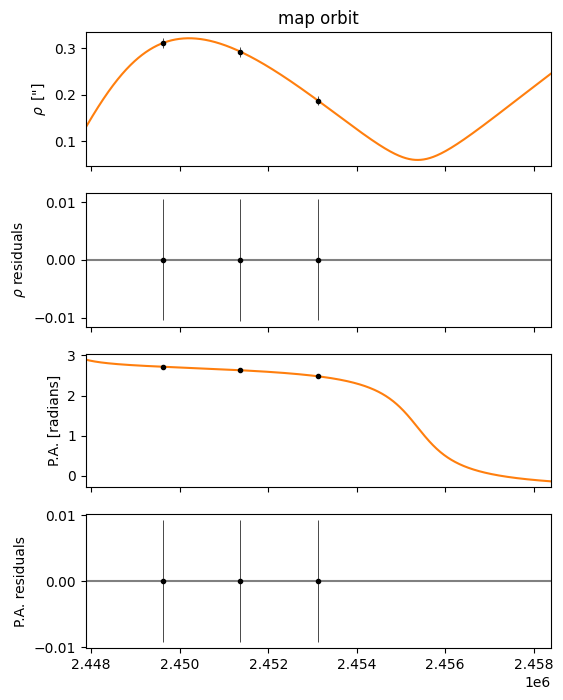

In [213]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(t_obs, rho, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    t_obs, rho - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(t_obs, theta, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    t_obs, theta - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

In [214]:
np.random.seed(1234)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=4,
        chains=1,
        target_accept=0.9,
        return_inferencedata=True,
    )

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 104 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 104 seconds.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


In [215]:
az.summary(
    trace,
    var_names=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"],
)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,2.935958e+10,3.915602e+11,5.264891e+03,1.695633e+09,2.722206e+10,1.927610e+10,19.0,34.0,NaN
tperi,-3.446412e+08,3.446903e+10,-1.222338e+08,1.622492e+08,1.080065e+09,8.779495e+08,174.0,34.0,NaN
a_ang,3.410000e-01,1.560000e-01,1.610000e-01,6.750000e-01,1.800000e-02,1.300000e-02,86.0,101.0,NaN
omega,1.063000e+00,2.597000e+00,-3.638000e+00,4.708000e+00,9.810000e-01,1.323000e+00,9.0,35.0,NaN
Omega,-1.173000e+00,2.110000e+00,-3.928000e+00,2.901000e+00,8.830000e-01,1.439000e+00,6.0,67.0,NaN
incl,1.837000e+00,3.760000e-01,1.067000e+00,2.715000e+00,3.900000e-02,2.800000e-02,81.0,85.0,NaN
ecc,4.710000e-01,3.030000e-01,5.000000e-03,9.320000e-01,5.200000e-02,3.700000e-02,30.0,111.0,NaN


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


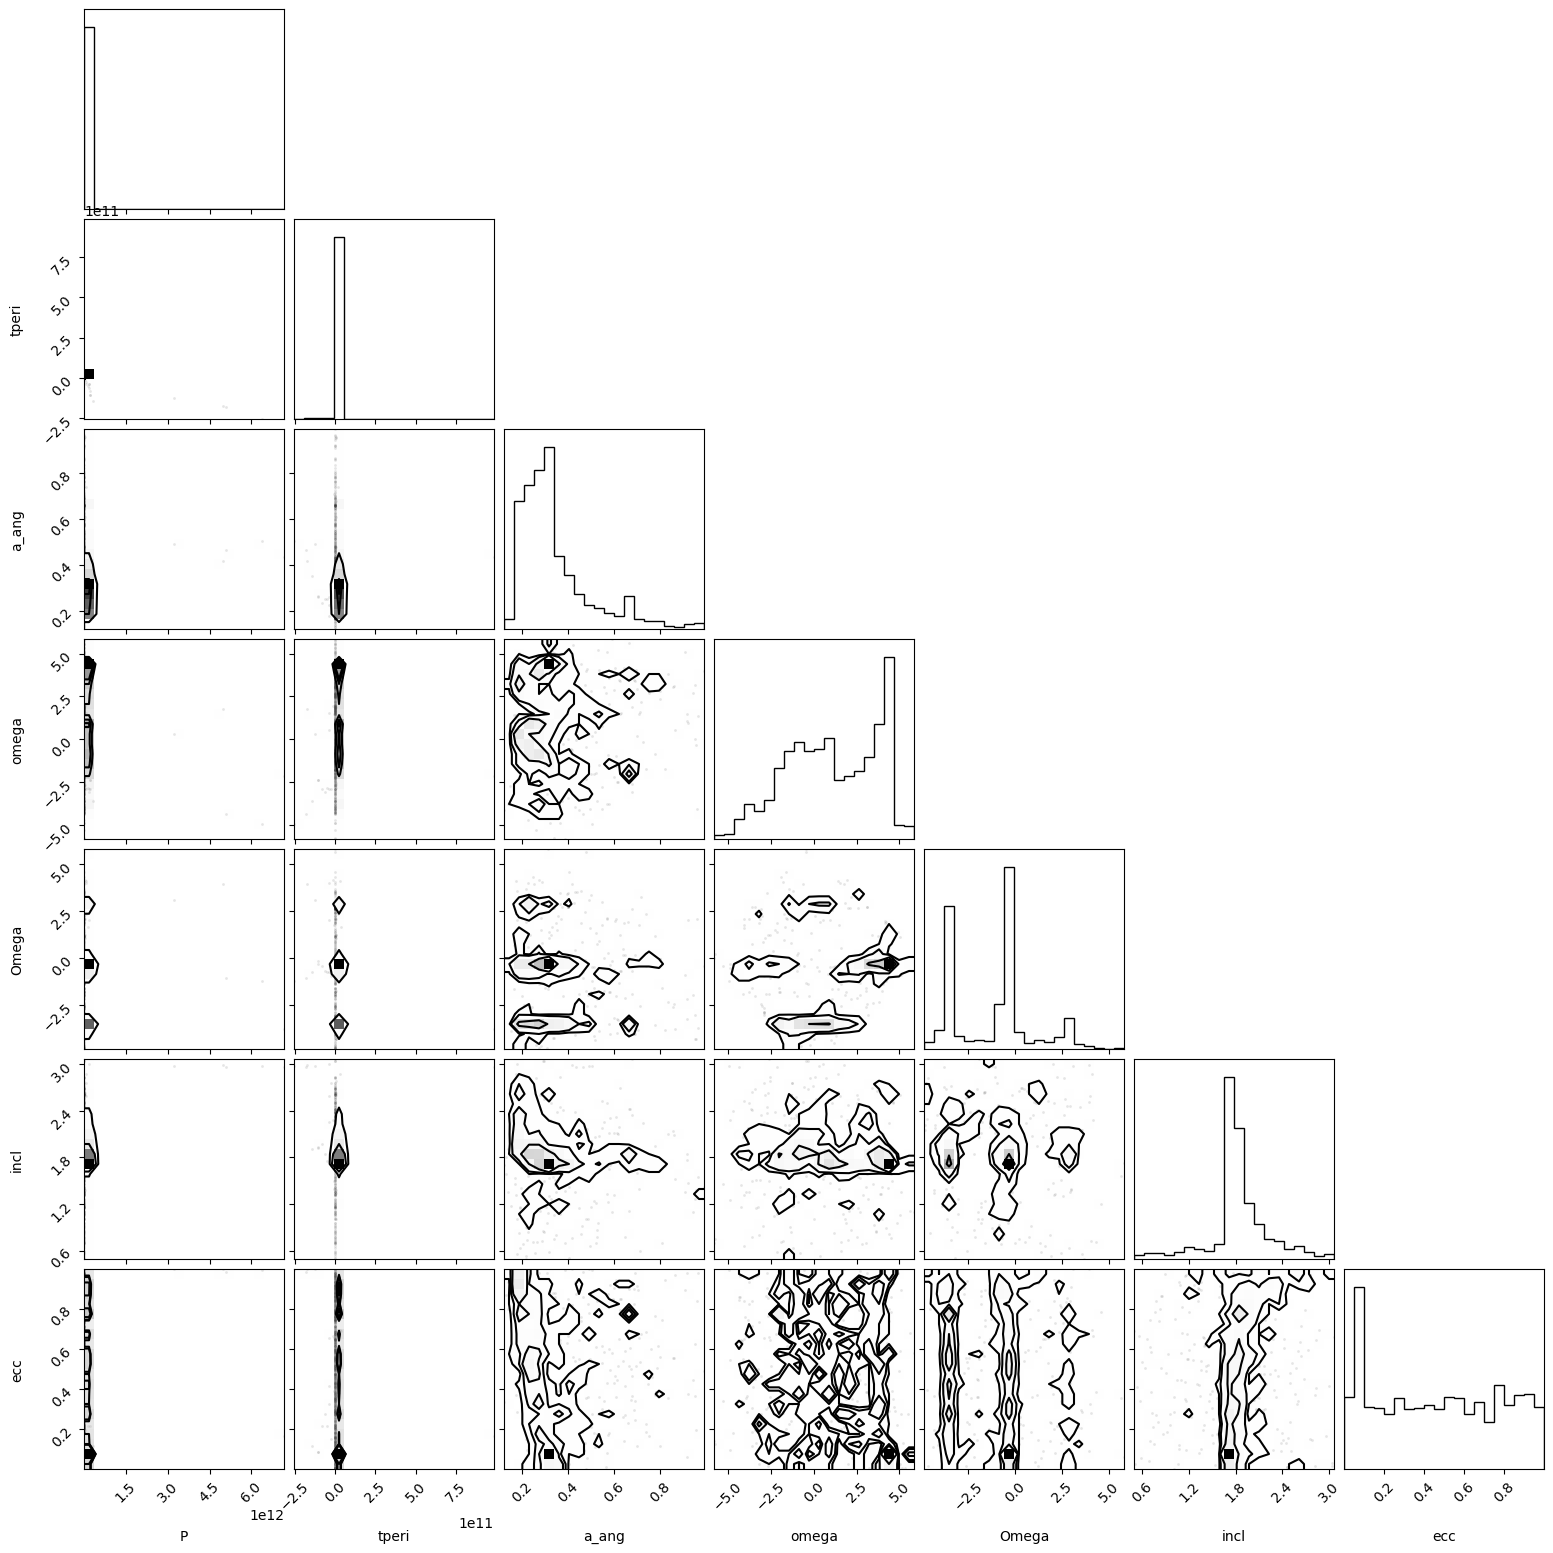

In [216]:
_ = corner.corner(
    trace, var_names=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"]
)

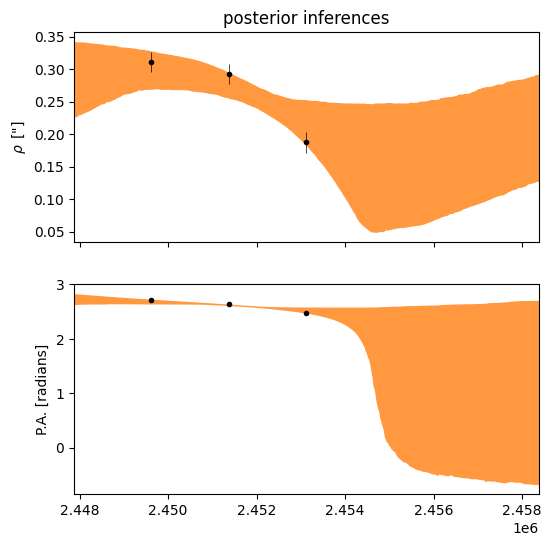

In [217]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err**2
    + np.exp(2 * np.median(trace.posterior["log_rho_s"].values, axis=(0, 1)))
)
tot_theta_err = np.sqrt(
    theta_err**2
    + np.exp(2 * np.median(trace.posterior["log_theta_s"].values, axis=(0, 1)))
)

ax[0].errorbar(t_obs, rho, yerr=tot_rho_err, **ekw)
q = np.percentile(trace.posterior["rho_save"].values, [16, 84], axis=(0, 1))
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(t_obs, theta, yerr=tot_theta_err, **ekw)
q = np.percentile(trace.posterior["theta_save"].values, [16, 84], axis=(0, 1))
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

In [218]:
trace.posterior['rho_save'].values.shape

(1, 1000, 1000)

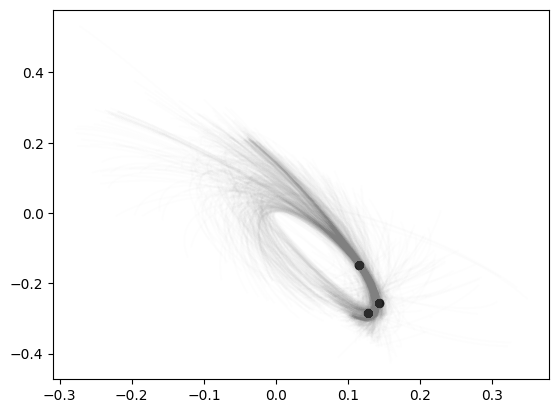

In [219]:
for i in range(1000):
    x = trace.posterior['rho_save'].values[0,i,:] * np.cos(trace.posterior['theta_save'].values[0,i,:])  # X is north
    y = trace.posterior['rho_save'].values[0,i,:] * np.sin(trace.posterior['theta_save'].values[0,i,:])  # Y is east
    plt.plot(y, x, color='gray', alpha=0.01)
# xs, ys, zs = true_orbit.get_relative_position(t_fine)
# plt.plot(ys.eval(), xs.eval(), color="red", lw=1)
x_point = rho * np.cos(theta)  # X is north
y_point = rho * np.sin(theta)  # Y is east

plt.scatter(y_point, x_point, color='black')

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 64 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 64 seconds.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 1 observation:
a: 10.9157 (+3.4479, -3.2867)
P: 27499.5352 (+14647.4941, -17762.0760)
ecc: 0.6155 (+0.2816, -0.3318)
incl: 2.0018 (+0.2815, -0.2520)
omega: 0.5733 (+1.9187, -1.5779)
Omega: -1.6317 (+3.6715, -2.0088)
tperi: 2449861.7002 (+7011.5359, -6859.9315)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 93 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 93 seconds.
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 2 observations:
a: 11.2758 (+4.0063, -3.9948)
P: 357791101.0460 (+-357713369.4368, -357780572.1970)
ecc: 0.5687 (+0.3129, -0.3542)
incl: 1.9254 (+0.2592, -0.1999)
omega: -2.3375 (+2.3779, -1.7942)
Omega: -0.7484 (+0.5699, -2.4566)
tperi: -57638383.3460 (+60095322.1183, --60079800.8844)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 104 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 104 seconds.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 3 observations:
a: 11.2708 (+3.8081, -3.8827)
P: 14310916.6655 (+-14271614.4401, -14301145.4273)
ecc: 0.6099 (+0.3202, -0.3881)
incl: 2.0115 (+0.3293, -0.2677)
omega: 1.8784 (+1.7656, -1.9886)
Omega: -1.2565 (+1.0753, -2.2576)
tperi: 3224981.2534 (+-768067.3210, -782256.4408)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 149 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 149 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 4 observations:
a: 13.8174 (+6.1713, -5.6340)
P: 1434229.2409 (+-1336903.7124, -1421615.1935)
ecc: 0.5724 (+0.3358, -0.3583)
incl: 1.9884 (+0.3698, -0.2555)
omega: 0.6223 (+2.1316, -2.2511)
Omega: -0.8192 (+1.0378, -2.5500)
tperi: 2756868.7320 (+-298234.2640, -315430.9676)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 38 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 38 seconds.
There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7194887897607448, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 5 observations:
a: 15.2929 (+5.4798, -5.7592)
P: 343310083810095.5000 (+-343308887381292.5625, -343310083782671.5000)
ecc: 0.4380 (+0.3581, -0.3026)
incl: 1.7773 (+0.5236, -0.6006)
omega: 0.7701 (+2.8873, -3.1178)
Omega: -0.0520 (+2.2073, -1.3650)
tperi: -132324364756245.5938 (+132324369259999.0938, --132324365202040.4375)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 85 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 85 seconds.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 6 observations:
a: 11.4652 (+4.5029, -3.7176)
P: 25795.0111 (+18842.8853, -15581.7282)
ecc: 0.6013 (+0.3282, -0.3526)
incl: 2.0006 (+0.3475, -0.2685)
omega: 0.5550 (+2.2084, -1.8224)
Omega: -0.9900 (+3.6931, -2.5983)
tperi: 2450358.9474 (+7401.6224, -7265.4856)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 54 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 54 seconds.
There were 368 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 368 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7098692434686509, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 7 observations:
a: 11.0220 (+2.2987, -1.7908)
P: 854404.8483 (+-820486.2090, -838968.5501)
ecc: 0.4030 (+0.3098, -0.2304)
incl: 1.8857 (+0.0878, -0.1255)
omega: -0.4341 (+0.5164, -0.8982)
Omega: 2.5320 (+0.3334, --0.0384)
tperi: 2544770.2949 (+-82232.3931, -100229.9087)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 124 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 124 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 8 observations:
a: 15.0994 (+8.1694, -6.6939)
P: 63306.7601 (+61803.5244, -51120.3280)
ecc: 0.5986 (+0.3163, -0.3622)
incl: 1.9830 (+0.3086, -0.2552)
omega: 0.5084 (+2.7234, -2.1578)
Omega: -0.3290 (+3.0469, -3.1134)
tperi: 2451550.5861 (+7099.7523, -8652.9302)


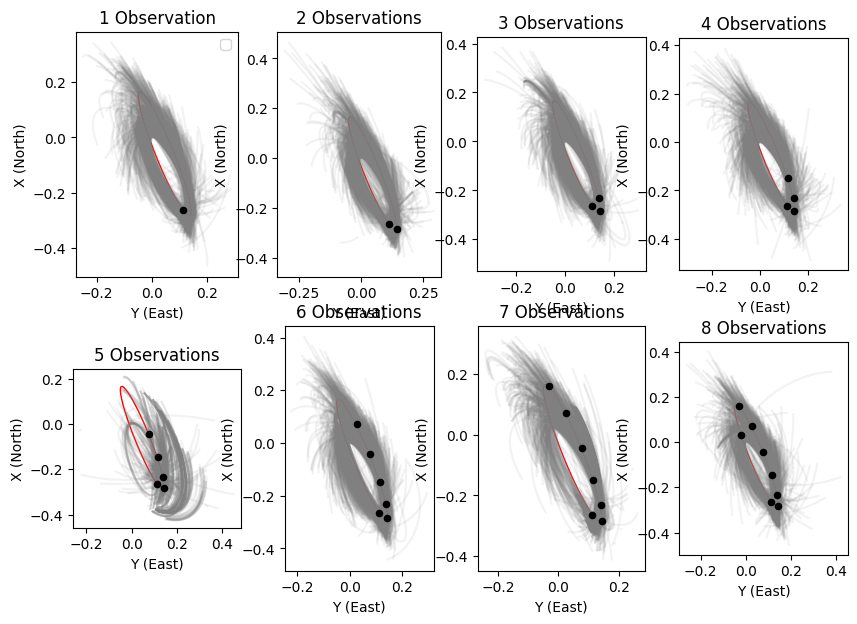

Text(0.5, 1.0, 'Inclination Uncertainty vs. Number of Observations')

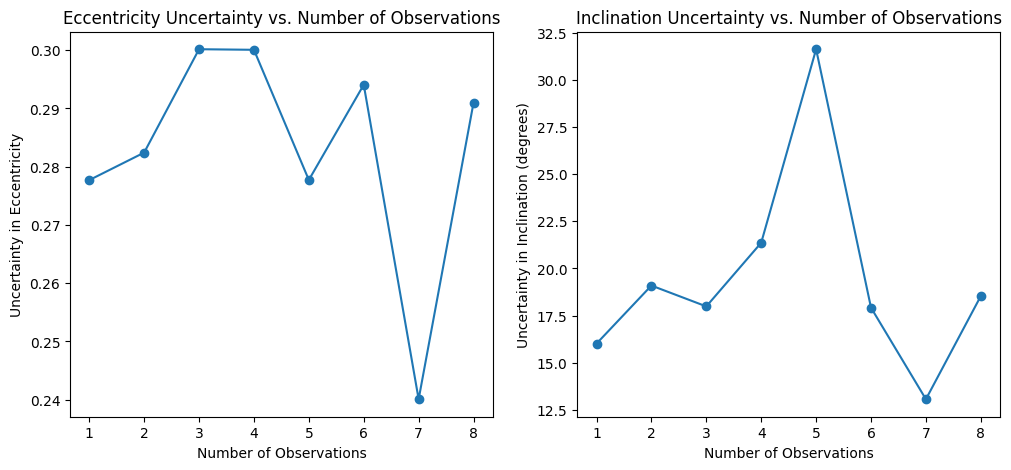

In [224]:
np.random.seed(42)
deg = np.pi / 180.0

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

true_a_ang = 0.324  # arcsec
true_parallax = 25  # mas
true_a = true_a_ang * au_to_R_sun / true_parallax
true_ecc = 0.3
true_incl = 96.0 * deg  # [rad]
true_omega = 251.6 * deg - np.pi  
true_Omega = 159.6 * deg
true_period = 18. * 365.25  # days

true_T0 = Time(1989.92, format="decimalyear")
true_T0.format = "jd"
true_T0 = true_T0.value  # [Julian Date]

true_orbit = xo.orbits.KeplerianOrbit(
    period=true_period,
    t_periastron=true_T0,
    a=true_a,
    incl=true_incl,
    ecc=true_ecc,
    omega=true_omega,
    Omega=true_Omega
)

n_observations = 9
t_obs = np.linspace(true_T0, true_T0 + true_period, n_observations)[1:]
rho, theta = true_orbit.get_relative_angles(t_obs, true_parallax)
rho = rho.eval()
theta = theta.eval()

rho_err = 0.01 
theta_err = np.radians(1) 
rho += np.random.normal(0, rho_err)
theta += np.random.normal(0, theta_err)

theta = np.mod(theta + np.pi, 2*np.pi) - np.pi

yr = 365.25
t_fine = np.linspace(true_T0, true_T0 + true_period + 1, 1001)[1:]

ecc_uncertainties = []
incl_uncertainties = []
def get_model(n_observations):
    with pm.Model() as model:
        # Below we will run a version of this model where a measurement of parallax is provided
        # The measurement is in milliarcsec
        m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
            "m_plx", mu=true_parallax, sd=0.45, testval=true_parallax
        )
        plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=true_a_ang)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(20 * yr), sd=10.0, testval=np.log(true_period * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = pmx.Angle("p", testval=0.5 * (Omega0 + omega0))
        m = pmx.Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periastron
        # passage directly
        phase = pmx.Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", true_T0 + P * phase / (2 * np.pi))

        # Geometric uniform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(true_incl * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=true_ecc)

        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        pm.Deterministic("M_tot", orbit.m_total)

        rho_model, theta_model = orbit.get_relative_angles(t_obs[:n_observations], plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=2.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=2.0
        )
        rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2 * log_theta_s))

        # define the likelihood function
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho[:n_observations])

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta[:n_observations]), tt.cos(theta_model - theta[:n_observations])
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = pmx.optimize(map_soln, vars=[phase])
        map_soln = pmx.optimize(map_soln, vars=[p, m, ecc])
        map_soln = pmx.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = pmx.optimize(map_soln)

    return model, map_soln

fig, axs = plt.subplots(2, 4, figsize=(10, 7))
for n in range(1,9):
    row = (n - 1) // 4
    col = (n - 1) % 4
    ax = axs[row, col]

    with model:
        trace = pmx.sample(
            tune=1000,
            draws=1000,
            start=map_soln,
            cores=4,
            chains=1,
            target_accept=0.9,
            return_inferencedata=True,
        )

    rho_true, theta_true = true_orbit.get_relative_angles(t_fine, true_parallax)
    xs = rho_true.eval() * np.cos(theta_true.eval())  # X is north
    ys = rho_true.eval() * np.sin(theta_true.eval())  # Y is east
    ax.plot(ys, xs, color="red", lw=1)
    trace.posterior['rho_save'].values.shape
    for i in range(1000):
        x = trace.posterior['rho_save'].values[0,i,:] * np.cos(trace.posterior['theta_save'].values[0,i,:])  # X is north
        y = trace.posterior['rho_save'].values[0,i,:] * np.sin(trace.posterior['theta_save'].values[0,i,:])  # Y is east

        ax.plot(y, x, color='gray', alpha=0.1)
    # ax.plot(ys, xs, color="red", lw=1)
    x_point = rho[:n] * np.cos(theta[:n])  # X is north
    y_point = rho[:n] * np.sin(theta[:n])  # Y is east

    ax.scatter(y_point, x_point, color='black', s=20, zorder=10)

    ax.set_aspect('equal', 'box')
    ax.set_title(f'{n} Observation{"s" if n > 1 else ""}')
    ax.set_xlabel('Y (East)')
    ax.set_ylabel('X (North)')
    
    if n == 1:
        ax.legend()

    ecc_uncertainties.append(np.std(trace.posterior['ecc'].values))
    incl_uncertainties.append(np.std(trace.posterior['incl'].values))
    
    print(f"\nResults for {n} observation{'s' if n > 1 else ''}:")
    for param in ['a', 'P', 'ecc', 'incl', 'omega', 'Omega', 'tperi']:
        mean = np.mean(trace.posterior[param].values)
        lower, upper = np.percentile(trace.posterior[param].values, [16, 84])
        print(f"{param}: {mean:.4f} (+{upper-mean:.4f}, -{mean-lower:.4f})")

plt.show()


Text(0, 0.5, 'Uncertainty in Inclination (degrees)')

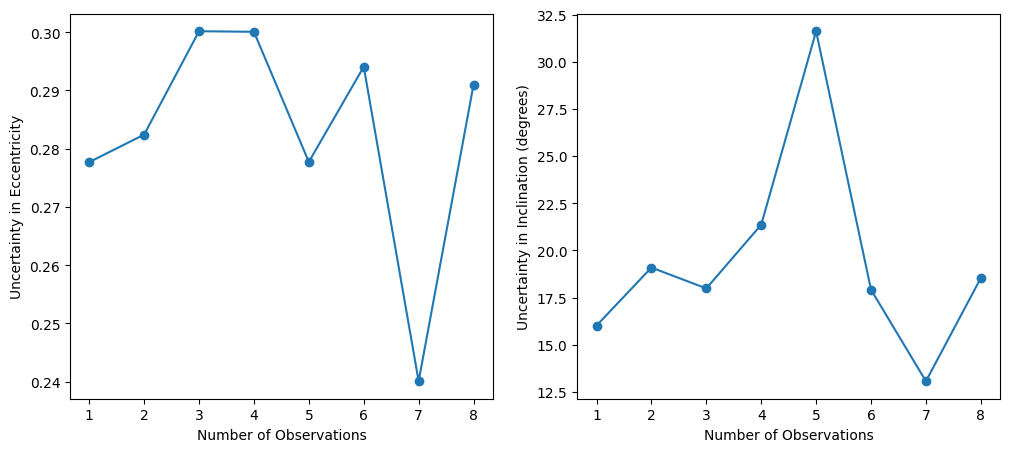

In [225]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, 9), ecc_uncertainties, 'o-')
ax1.set_xlabel('Number of Observations')
ax1.set_ylabel('Uncertainty in Eccentricity')

ax2.plot(range(1, 9), np.degrees(incl_uncertainties), 'o-')
ax2.set_xlabel('Number of Observations')
ax2.set_ylabel('Uncertainty in Inclination (degrees)')

In [294]:
def get_model(n_observations):
    with pm.Model() as model:
        # Below we will run a version of this model where a measurement of parallax is provided
        # The measurement is in milliarcsec
        m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
            "m_plx", mu=true_parallax, sd=0.45, testval=true_parallax
        )
        plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 8.0, testval=true_a_ang)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(true_period), sd=10.0, testval=np.log(true_period * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        # omega0 = 251.6 * deg - np.pi
        # Omega0 = 159.6 * deg
        # p = pmx.Angle("p", testval=0.5 * (Omega0 + omega0))
        # m = pmx.Angle("m", testval=0.5 * (Omega0 - omega0))
        # omega = pm.Deterministic("omega", p - m)
        # Omega = pm.Deterministic("Omega", p + m)
        omega = pmx.Angle("omega", testval=true_omega)
        Omega = pmx.Angle("Omega", testval=true_Omega)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periastron
        # passage directly
        phase = pmx.Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", true_T0 + P * phase / (2 * np.pi))

        # Geometric uniform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(true_incl * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc",0., 1., testval=true_ecc)

        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        pm.Deterministic("M_tot", orbit.m_total)

        rho_model, theta_model = orbit.get_relative_angles(t_obs[:n_observations], plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err[:n_observations])), sd=2.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err[:n_observations])), sd=2.0
        )
        rho_tot_err = tt.sqrt(rho_err[:n_observations]**2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err[:n_observations]**2 + tt.exp(2 * log_theta_s))

        # define the likelihood function
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho[:n_observations])

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta[:n_observations]), tt.cos(theta_model - theta[:n_observations])
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, vars=[log_rho_s, log_theta_s, phase, omega, Omega, ecc, logP, a_ang, phase])

    return model, map_soln

In [289]:
30 * 50 / au_to_R_sun

6.975700891443236

In [300]:
t_obs

array([2448906.87143922, 2449950.44286779, 2450994.01429636,
       2452037.58572493, 2453081.15715351, 2454124.72858208,
       2455168.30001065])

In [295]:
np.random.seed(42)
deg = np.pi / 180.0

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

true_a_ang = 6.9  # arcsec
true_parallax = 50  # mas
true_a = true_a_ang * au_to_R_sun / true_parallax
true_ecc = 0.6
true_incl = 89.0 * deg  # [rad]
true_omega = 45.0 * deg - np.pi  
true_Omega = 159 * deg
true_period = 10. * 365.25  # days

true_T0 = Time(1989.92, format="decimalyear")
true_T0.format = "jd"
true_T0 = true_T0.value  # [Julian Date]

true_orbit = xo.orbits.KeplerianOrbit(
    period=true_period,
    t_periastron=true_T0,
    a=true_a,
    incl=true_incl,
    ecc=true_ecc,
    omega=true_omega,
    Omega=true_Omega,
)

# Generate more observations over a longer time span
n_observations_max = 8
t_obs = np.linspace(true_T0, true_T0 + 2*true_period, n_observations_max)[1:]
rho, theta = true_orbit.get_relative_angles(t_obs, true_parallax)
rho = rho.eval()
theta = theta.eval()

# Add noise to observations
rho_err = 0.01 * np.ones_like(rho)
theta_err = np.radians(1) * np.ones_like(theta)
rho += np.random.normal(0, rho_err)
theta += np.random.normal(0, theta_err)

theta = np.mod(theta + np.pi, 2*np.pi) - np.pi

yr = 365.25
t_fine = np.linspace(true_T0, true_T0 + 2*true_period + 1, 1001)[1:]

ecc_uncertainties = []
incl_uncertainties = []
sma_uncertainties = []
traces = []

for n in range(1, n_observations_max + 1):
    
    model, map_soln = get_model(n)
    
    with model:
        trace = pmx.sample(
            tune=1000,
            draws=1000,
            start=map_soln,
            cores=4,
            chains=1,
            target_accept=0.9,
            return_inferencedata=True,
        )
        traces.append(trace)

    ecc_uncertainties.append(np.std(trace.posterior['ecc'].values))
    incl_uncertainties.append(np.std(trace.posterior['incl'].values))
    sma_uncertainties.append(np.std(trace.posterior['a'].values))
    
    print(f"\nResults for {n} observation{'s' if n > 1 else ''}:")
    for param in ['a', 'P', 'ecc', 'incl', 'omega', 'Omega', 'tperi']:
        mean = np.mean(trace.posterior[param].values)
        lower, upper = np.percentile(trace.posterior[param].values, [16, 84])
        print(f"{param}: {mean:.4f} (+{upper-mean:.4f}, -{mean-lower:.4f})")

optimizing logp for variables: [phase, a_ang, logP, ecc, Omega, omega, log_theta_s, log_rho_s]


message: Desired error not necessarily achieved due to precision loss.
logp: -103336.37005660782 -> 51.40258658358699
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 27 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 27 seconds.
There were 765 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 765 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23206865047584518, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 1 observation:
a: 102.9640 (+0.8740, -0.9967)
P: 1472815926.0842 (+705387685.5717, -723232390.2134)
ecc: 0.7807 (+0.0171, -0.0163)
incl: 2.5224 (+0.0223, -0.0159)
omega: 2.9404 (+0.0141, -0.0161)
Omega: 2.6817 (+0.0144, -0.0129)
tperi: 664130324.6584 (+325757303.8537, -330604072.2087)


optimizing logp for variables: [phase, a_ang, logP, ecc, Omega, omega, log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: -143247.03165874936 -> 44.839705413837706
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 53 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 53 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 2 observations:
a: 121.7495 (+26.6577, -26.5247)
P: 37692062575728272.0000 (+-37692054151097336.0000, -37692062575589176.0000)
ecc: 0.5951 (+0.3112, -0.3320)
incl: 1.5406 (+0.8087, -0.7864)
omega: 0.0367 (+2.3979, -2.4339)
Omega: 0.8427 (+1.9692, -1.6861)
tperi: -9146913509595920.0000 (+9146913572478086.0000, --9146913414024080.0000)


optimizing logp for variables: [phase, a_ang, logP, ecc, Omega, omega, log_theta_s, log_rho_s]


message: Desired error not necessarily achieved due to precision loss.
logp: -149005.69334090437 -> 56.521571951366184
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 37 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 37 seconds.
There were 812 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 812 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1555703845240402, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 3 observations:
a: 115.3855 (+0.1236, -0.1286)
P: 615.7655 (+0.1276, -0.1024)
ecc: 0.6008 (+0.0006, -0.0005)
incl: 1.4836 (+0.0062, -0.0044)
omega: -0.0592 (+0.0031, -0.0031)
Omega: -0.3075 (+0.0003, -0.0002)
tperi: 2447938.0186 (+0.3940, -0.4202)


optimizing logp for variables: [phase, a_ang, logP, ecc, Omega, omega, log_theta_s, log_rho_s]


message: Desired error not necessarily achieved due to precision loss.
logp: -187470.1706504682 -> -18.520482932295035
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 52 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 52 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 4 observations:
a: 112.4005 (+5.5108, -5.6234)
P: 4179.5061 (+182.0270, -213.2189)
ecc: 0.6681 (+0.0436, -0.0439)
incl: 1.5292 (+0.0187, -0.0220)
omega: -2.6590 (+-0.0611, -0.3594)
Omega: 2.7728 (+0.0116, -0.0108)
tperi: 2446968.6423 (+296.1223, -275.5572)


optimizing logp for variables: [phase, a_ang, logP, ecc, Omega, omega, log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: -279516.3522543869 -> 45.59695581530098
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 34 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 34 seconds.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 5 observations:
a: 122.0880 (+12.9638, -14.8677)
P: 3875.0721 (+251.3440, -210.9816)
ecc: 0.6351 (+0.0553, -0.0422)
incl: 1.5471 (+0.0121, -0.0177)
omega: -2.1999 (+-0.1376, -0.7212)
Omega: 2.7732 (+0.0101, -0.0099)
tperi: 2447409.2449 (+386.7447, -472.6695)


optimizing logp for variables: [phase, a_ang, logP, ecc, Omega, omega, log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: -283869.3351591884 -> 11.487858323734121
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 22 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 6 observations:
a: 137.8956 (+1.5092, -1.5121)
P: 3652.7540 (+2.1097, -2.4384)
ecc: 0.6002 (+0.0019, -0.0022)
incl: 1.5544 (+0.0033, -0.0031)
omega: -2.3588 (+0.0099, -0.0097)
Omega: 2.7754 (+0.0069, -0.0070)
tperi: 2447860.0073 (+7.2590, -6.9451)


optimizing logp for variables: [phase, a_ang, logP, ecc, Omega, omega, log_theta_s, log_rho_s]


message: Desired error not necessarily achieved due to precision loss.
logp: -286267.0626103029 -> -48.113665634209866
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 52 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 52 seconds.
There were 697 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 697 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6904028396426531, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossibl


Results for 7 observations:
a: 134.9674 (+3.0013, -3.0607)
P: 3670.5291 (+17.8586, -21.3713)
ecc: 0.5984 (+0.0187, -0.0154)
incl: 1.5540 (+0.0043, -0.0042)
omega: 0.7682 (+0.0521, -0.0480)
Omega: -0.3701 (+0.0071, -0.0078)
tperi: 2447828.5766 (+39.4914, -41.3294)


optimizing logp for variables: [phase, a_ang, logP, ecc, Omega, omega, log_theta_s, log_rho_s]


message: Desired error not necessarily achieved due to precision loss.
logp: -286267.0626103029 -> -48.113665634209866
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
INFO:pymc3:The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]
INFO:pymc3:NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


/Users/sabina/miniconda3/envs/starry-debug/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 81 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 81 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks



Results for 8 observations:
a: 138.2765 (+1.2826, -1.2820)
P: 3653.2413 (+1.7262, -1.7939)
ecc: 0.6008 (+0.0012, -0.0012)
incl: 1.5551 (+0.0031, -0.0034)
omega: 0.7879 (+0.0034, -0.0036)
Omega: -0.3705 (+0.0075, -0.0073)
tperi: 2447863.0557 (+3.9205, -3.8917)


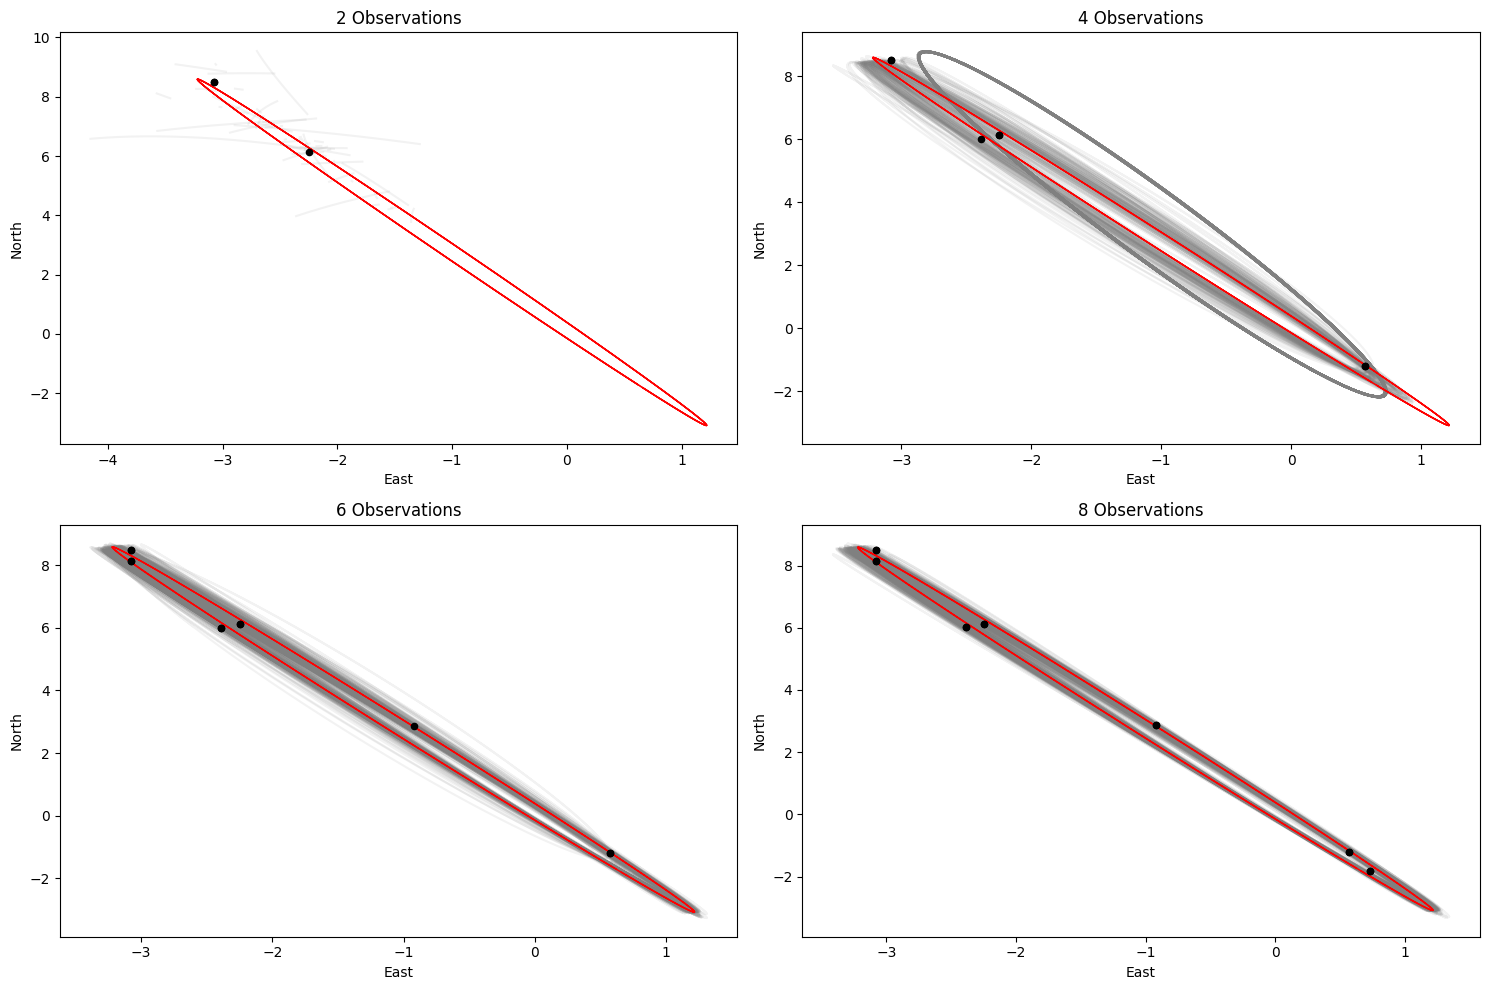

In [299]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
rho_true, theta_true = true_orbit.get_relative_angles(t_fine, true_parallax)
xs = rho_true.eval() * np.cos(theta_true.eval())  # X is north
ys = rho_true.eval() * np.sin(theta_true.eval())  # Y is east

for n, trace in enumerate(traces):  # Every second trace
    ax = axs[n // 2]  # Integer division to get the correct subplot
    
    for i in range(100):  # Reduced from 1000 to 100 for faster plotting
        x = trace.posterior['rho_save'].values[0,i,:] * np.cos(trace.posterior['theta_save'].values[0,i,:])
        y = trace.posterior['rho_save'].values[0,i,:] * np.sin(trace.posterior['theta_save'].values[0,i,:])
        ax.plot(y, x, color='gray', alpha=0.1)

    ax.plot(ys, xs, color="red", lw=1)
    x_point = rho[:n+1] * np.cos(theta[:n+1])
    y_point = rho[:n+1] * np.sin(theta[:n+1])
    ax.scatter(y_point, x_point, color='black', s=20, zorder=10)
    
    ax.set_title(f'{n+1} Observations')
    ax.set_xlabel('East')
    ax.set_ylabel('North')
    # ax.legend(['samples', 'observations'])

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Uncertainty in Semi-major axes')

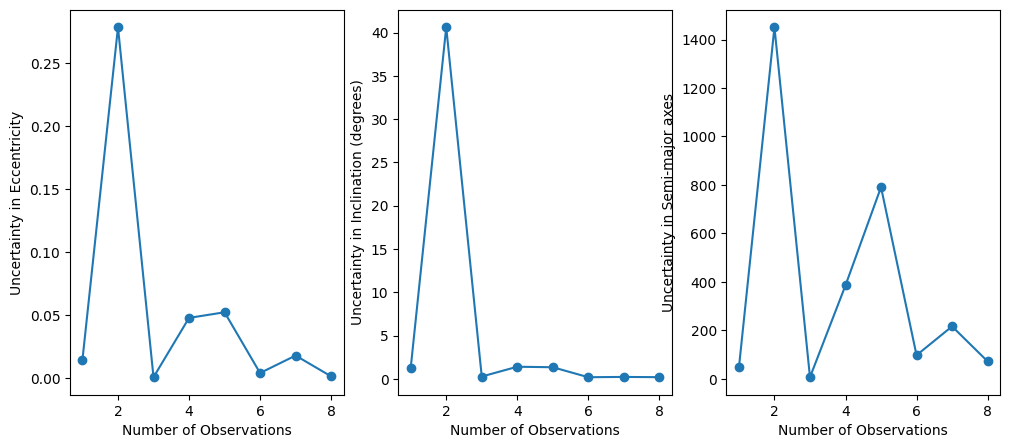

In [298]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.plot(range(1, 9), ecc_uncertainties, 'o-')
ax1.set_xlabel('Number of Observations')
ax1.set_ylabel('Uncertainty in Eccentricity')

ax2.plot(range(1, 9), np.degrees(incl_uncertainties), 'o-')
ax2.set_xlabel('Number of Observations')
ax2.set_ylabel('Uncertainty in Inclination (degrees)')

ax3.plot(range(1, 9), np.degrees(sma_uncertainties), 'o-')
ax3.set_xlabel('Number of Observations')
ax3.set_ylabel('Uncertainty in Semi-major axes')